In [1]:
from os import listdir
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepaths = glob.glob("../data/tidy/acetaminophen/*_events_*.csv")
df = pd.concat(map(pd.read_csv, filepaths))
df["CLINICAL_EVENT_DATETIME"] = pd.to_datetime(df["CLINICAL_EVENT_DATETIME"])
df.index = df["CLINICAL_EVENT_DATETIME"]

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108238 entries, 2016-07-02 20:48:00 to 2019-04-28 21:30:00
Data columns (total 20 columns):
ADMIN_EVENT                76519 non-null object
ADMIN_START_DATETIME       108238 non-null object
CDM                        1921 non-null float64
CLINICAL_EVENT_DATETIME    108238 non-null datetime64[ns]
DOSE                       108238 non-null float64
DOSE_UNIT                  108238 non-null object
ENCOUNTER_ID               108238 non-null int64
ENCOUNTER_TYPE             108238 non-null object
EVENT_ID                   108238 non-null int64
FACILITY_EVENT             108238 non-null object
NURSE_UNIT                 108238 non-null object
NURSE_UNIT_EVENT           76519 non-null object
ORDER_ID                   108238 non-null int64
ORIG_ORDER_ID              108238 non-null int64
PO_MED                     108238 non-null bool
PRN_DOSE                   108238 non-null bool
PRODUCT_NAME               1921 non-null object
QUANTITY 

In [3]:
apap_daily = df.resample("D").count()[["EVENT_ID"]]
apap_daily.columns = ["Doses"]

In [7]:
apap_daily.tail()

,Doses
CLINICAL_EVENT_DATETIME,
2019-04-30,45
2019-05-01,55
2019-05-02,76
2019-05-03,57
2019-05-04,35


In [4]:
ts_apap = df.loc[:"2019-04-30"].resample("MS").count()[["EVENT_ID"]]
ts_apap.columns = ["Doses"]

In [5]:
ts_apap.tail()

,Doses
CLINICAL_EVENT_DATETIME,
2018-12-01,3241
2019-01-01,2621
2019-02-01,1819
2019-03-01,1985
2019-04-01,1707


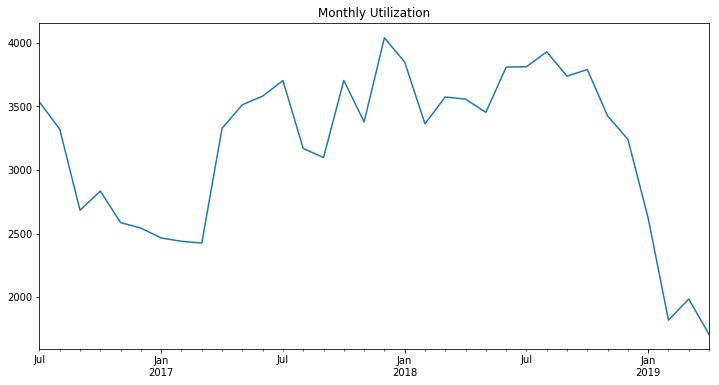

In [6]:
ax = ts_apap.plot(legend=False, figsize=(12, 6), title="Monthly Utilization")
ax.set(xlabel="");

In [4]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

In [5]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

## ARIMA Model

Check for seasonality

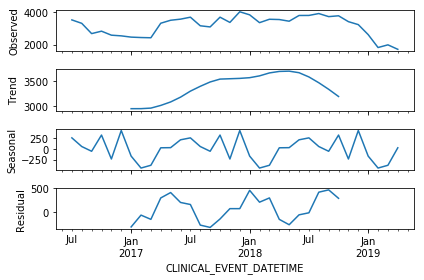

In [27]:
seasonal_decompose(ts_apap, model="add").plot();

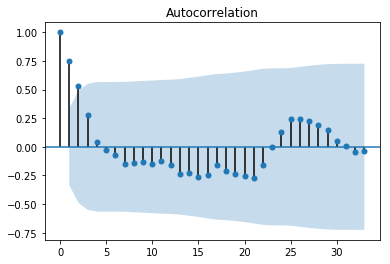

In [28]:
plot_acf(ts_apap);

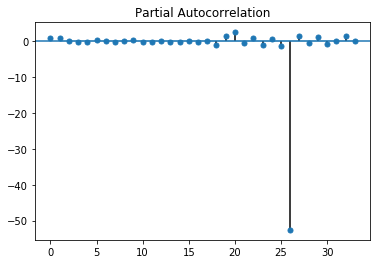

In [29]:
plot_pacf(ts_apap);

In [9]:
adf_test(ts_apap)

Augmented Dickey-Fuller Test: 


NameError: name 'adfuller' is not defined

In [ ]:
#ts_diff = ts_month.diff().diff().diff().diff().diff().diff()
#ts_diff.dropna(inplace=True)
#ts_diff = diff(ts_month["Sugammadex"], k_diff=12)
#adf_test(ts_diff)

In [6]:
auto_arima(ts_apap, seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(2, 2)   Log Likelihood                -244.223
Method:                       css-mle   S.D. of innovations            287.658
Date:                Fri, 03 May 2019   AIC                            500.445
Time:                        14:04:34   BIC                            509.603
Sample:                             0   HQIC                           503.568
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3205.6831    200.187     16.013      0.000    2813.323    3598.043
ar.L1.y        1.0476      0.169      6.212      0.000       0.717       1.378
ar.L2.y       -0.4566      0.178     -2.561      0.016      -0.806      -0.107
ma.L1.y       -0.2840      0.095     -2.996      0.006      -0.470      -0.098
ma.L2.y        1.0000      0.288      3.476      0.002       0.436       1.564
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1470           -0.9350j            1.4798           -0.1089
AR.2            1.1470           +0.9350j            1.4798            0.1089
MA.1            0.1420           -0.9899j            1.0000           -0.2273
MA.2            0.1420           +0.9899j            1.0000            0.2273
-----------------------------------------------------------------------------
"""

In [27]:
n = 12
train = ts_apap.iloc[:len(ts_apap)-n]
test = ts_apap.iloc[len(ts_apap)-n:]

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [34]:
model = ARIMA(scaled_train, order=(2, 1, 2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   21
Model:                 ARIMA(2, 1, 2)   Log Likelihood                   4.403
Method:                       css-mle   S.D. of innovations              0.178
Date:                Fri, 03 May 2019   AIC                              3.194
Time:                        14:08:44   BIC                              9.461
Sample:                             1   HQIC                             4.554
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.038      0.040      0.969      -0.072       0.075
ar.L1.D.y     -1.1588      0.110    -10.521      0.000      -1.375      -0.943
ar.L2.D.y     -0.9814      0.064    -15.391      0.000      -1.106      -0.856
ma.L1.D.y      1.0412      0.270      3.863      0.001       0.513       1.570
ma.L2.D.y      1.0000      0.189      5.296      0.000       0.630       1.370
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5904           -0.8188j            1.0094           -0.3494
AR.2           -0.5904           +0.8188j            1.0094            0.3494
MA.1           -0.5206           -0.8538j            1.0000           -0.3371
MA.2           -0.5206           +0.8538j            1.0000            0.3371
-----------------------------------------------------------------------------
"""

In [35]:
start = len(train)
end = len(ts_apap)-1
predictions = results.predict(start, end)

In [36]:
predictions = predictions.reshape((n, 1))
true_preds = scaler.inverse_transform(predictions)
test["Predictions"] = true_preds

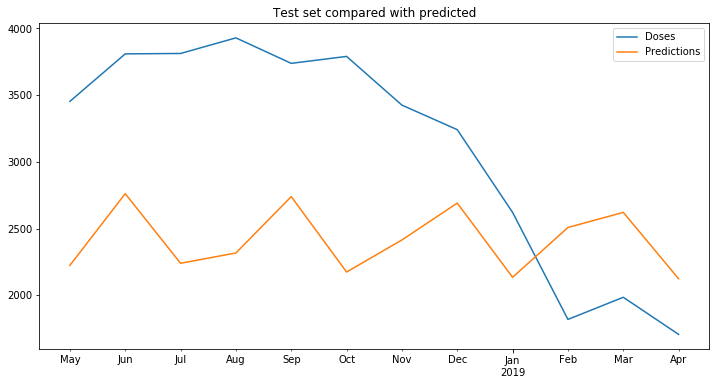

In [37]:
ax = test.plot(legend=True, figsize=(12, 6), title="Test set compared with predicted")
#true_preds.plot(legend=True)
ax.set(xlabel="");

In [38]:
mse_arima = mean_squared_error(test["Doses"], test["Predictions"])
rmse_arima = rmse(test["Doses"], test["Predictions"])

print(f'MSE ARIMA: {mse_arima:11.10}')
print(f'RMSE ARIMA: {rmse_arima:11.10}')

MSE ARIMA: 1158247.429
RMSE ARIMA: 1076.219043


In [41]:
n_forecast = 12
model = ARIMA(ts_apap, order=(2, 0, 2))
results = model.fit()
fcast = results.predict(start=len(ts_apap), end=len(ts_apap)+(n_forecast-1)).rename("Forecast")

In [172]:
fcast

2019-05-01    367.334437
2019-06-01    379.666160
2019-07-01    391.997883
2019-08-01    404.329607
2019-09-01    416.661330
2019-10-01    428.993054
2019-11-01    441.324777
2019-12-01    453.656500
2020-01-01    465.988224
2020-02-01    478.319947
2020-03-01    490.651671
2020-04-01    502.983394
Freq: MS, Name: ARIMA Forecast, dtype: float64

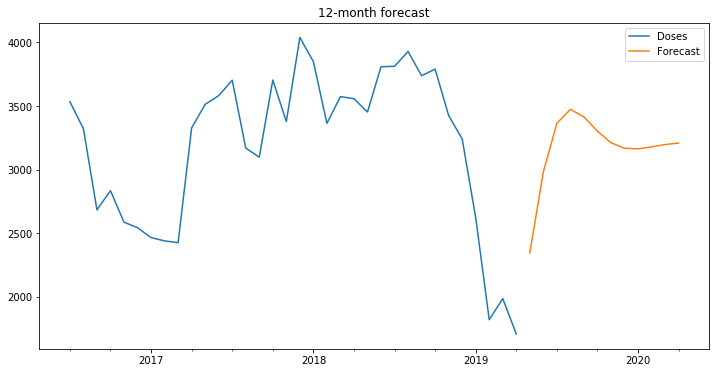

In [42]:
ax = ts_apap.plot(legend=True, figsize=(12, 6), title="12-month forecast")
fcast.plot(legend=True)
ax.set(xlabel="");

## RNN

In [75]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [79]:
n_daily = 90
batch = 30

In [92]:
l = len(apap_daily) - n_daily
v = int(l * 0.8)
train_set = apap_daily.iloc[:l]
train = apap_daily.iloc[:v]
valid = apap_daily.iloc[v:l]
test = apap_daily.iloc[l:]

In [112]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_valid = scaler.transform(valid)
scaled_train_set = scaler.transform(train_set)
scaled_test = scaler.transform(test)

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [94]:
#n_samp = len(apap_daily)
#n_hid = n_samp / (2 * (n_daily + 1))
n_hid = int(2/3 * (n_daily + 1))

In [95]:
gen = TimeseriesGenerator(scaled_train, scaled_train, length=n_daily, batch_size=batch)

In [109]:
gen_valid = TimeseriesGenerator(scaled_valid, scaled_valid, length=n_daily, batch_size=batch)

In [96]:
model = Sequential()
#model.add(LSTM(150, input_shape=(n_input, 1)))
#model.add(LSTM(300, activation="relu", input_shape=(n_input, 1), return_sequences=True))
#model.add(LSTM(300, activation="relu", input_shape=(n_input, 1), return_sequences=True))
model.add(LSTM(n_hid, activation="relu", input_shape=(n_daily, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60)                14880     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [110]:
model.fit_generator(gen, epochs=100, validation_data=gen_valid)

Epoch 1/100
23/23 [==============================] - 9s 395ms/step - loss: 0.1252 - val_loss: 0.0278
Epoch 2/100
23/23 [==============================] - 4s 172ms/step - loss: 0.0292 - val_loss: 0.0266
Epoch 3/100
23/23 [==============================] - 4s 169ms/step - loss: 0.0283 - val_loss: 0.0270
Epoch 4/100
23/23 [==============================] - 4s 179ms/step - loss: 0.0261 - val_loss: 0.0273
Epoch 5/100
23/23 [==============================] - 4s 169ms/step - loss: 0.0263 - val_loss: 0.0258
Epoch 6/100
23/23 [==============================] - 4s 172ms/step - loss: 0.0256 - val_loss: 0.0266
Epoch 7/100
23/23 [==============================] - 4s 174ms/step - loss: 0.0273 - val_loss: 0.0262
Epoch 8/100
23/23 [==============================] - 5s 219ms/step - loss: 0.0256 - val_loss: 0.0272
Epoch 9/100
23/23 [==============================] - 4s 169ms/step - loss: 0.0270 - val_loss: 0.0255
Epoch 10/100
23/23 [==============================] - 4s 187ms/step - loss: 0.0259 - val_lo

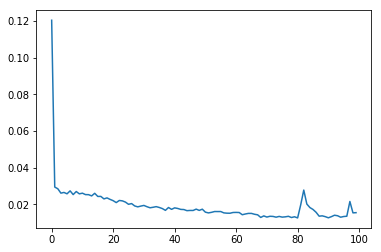

In [111]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [113]:
test_preds = []
first_batch = scaled_train_set[-n_daily:]
current_batch = first_batch.reshape((1, n_daily, 1))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_preds.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [114]:
true_preds = scaler.inverse_transform(test_preds)
test["Predictions"] = true_preds

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


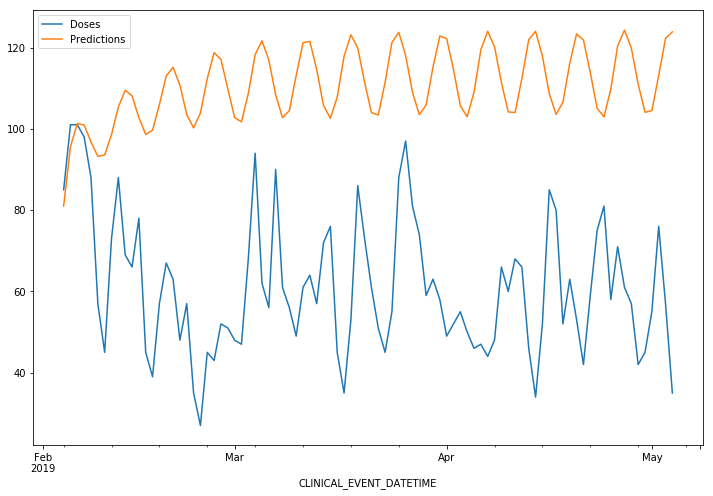

In [115]:
test.plot(figsize=(12, 8));

In [116]:
mse_rnn = mean_squared_error(test["Doses"], test["Predictions"])
rmse_rnn = rmse(test["Doses"],  test["Predictions"])

print(f'MSE RNN: {mse_rnn:11.10}')
print(f'RMSE RNN: {rmse_rnn:11.10}')

MSE RNN: 2869.595206
RMSE RNN:  53.5686028


In [59]:
#idx = pd.date_range('5/5/2019', periods=n_daily, freq="D")
#df_preds = pd.DataFrame(true_preds, index=idx)
#df_preds.columns = ["Predictions"]

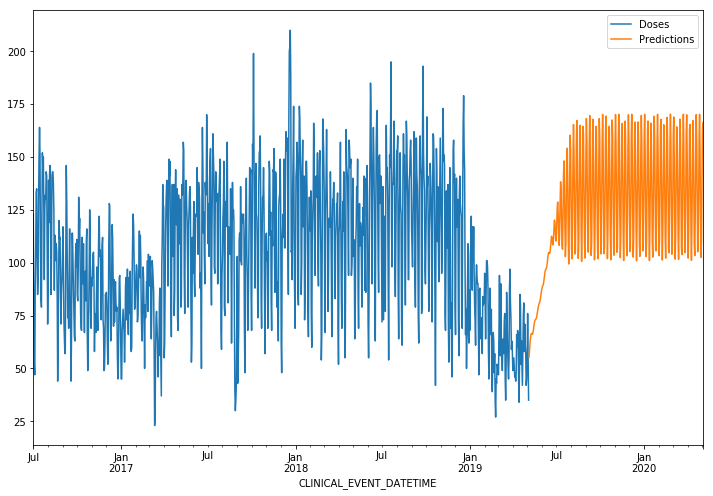

In [60]:
#ax = apap_daily["Doses"].plot(figsize=(12, 8), legend=True)
#df_preds["Predictions"].plot(legend=True)
#ax.autoscale(axis='x',tight=True)

In [55]:
n_input = 4
train = ts_apap.iloc[:len(ts_apap)-n_input]
test = ts_apap.iloc[len(ts_apap)-n_input:]

In [56]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [57]:
model = Sequential()
#model.add(LSTM(150, input_shape=(n_input, 1)))
#model.add(LSTM(300, activation="relu", input_shape=(n_input, 1), return_sequences=True))
#model.add(LSTM(300, activation="relu", input_shape=(n_input, 1), return_sequences=True))
model.add(LSTM(150, activation="relu", input_shape=(n_input, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit_generator(generator, epochs=100)

Epoch 1/100
26/26 [==============================] - 3s 109ms/step - loss: 0.2607
Epoch 2/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0871
Epoch 3/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0610
Epoch 4/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0594
Epoch 5/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0590
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0573
Epoch 7/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0573
Epoch 8/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0582
Epoch 9/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0550
Epoch 10/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0529
Epoch 11/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0524
Epoch 12/100
26/26 [==============================] - 1s 19ms/step - loss: 0.0516
Epoch 13/100
26/26 [====

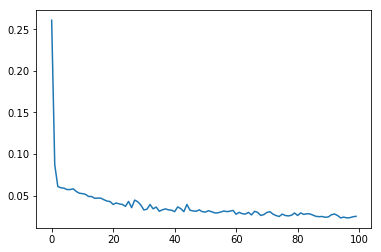

In [59]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [60]:
test_preds = []
first_batch = scaled_train[-n_input:]
current_batch = first_batch.reshape((1, n_input, 1))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_preds.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [61]:
true_preds = scaler.inverse_transform(test_preds)
test["Predictions"] = true_preds

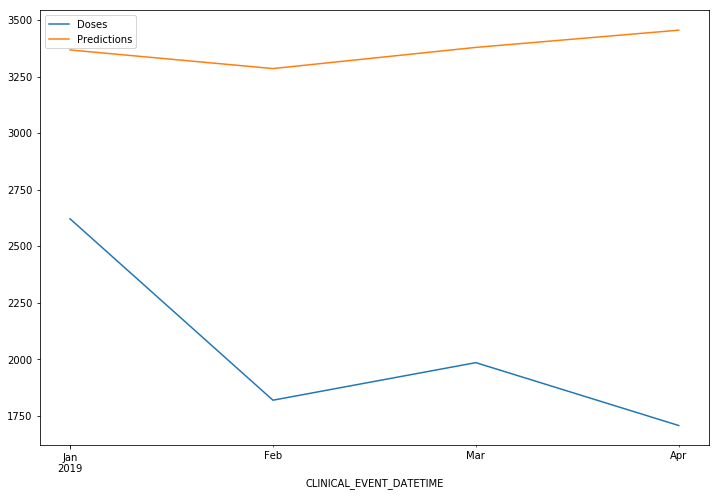

In [62]:
test.plot(figsize=(12, 8));

In [63]:
mse_rnn = mean_squared_error(test["Doses"], test["Predictions"])
rmse_rnn = rmse(test["Doses"],  test["Predictions"])

print(f'MSE RNN: {mse_rnn:11.10}')
print(f'RMSE RNN: {rmse_rnn:11.10}')

MSE RNN:  1925923.63
RMSE RNN: 1387.776506


In [154]:
n_back = 90
l = len(apap_daily) - n_back
train = apap_daily.iloc[:l]
test = apap_daily.iloc[l:]

In [155]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [156]:
features_set = []  
labels = []  
for i in range(n_back, len(train)):  
    features_set.append(train_scaled[i-n_back:i, 0])
    labels.append(train_scaled[i, 0])

In [157]:
features_set, labels = np.array(features_set), np.array(labels) 

In [158]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))  

In [159]:
n_units = int(2/3 * (n_back + 1))
model = Sequential()  
model.add(LSTM(units=n_units, return_sequences=False, input_shape=(features_set.shape[1], 1)))  
model.add(Dropout(0.2))  
model.add(Dense(units=1))  
model.compile(optimizer='adam', loss='mean_squared_error') 

In [160]:
model.fit(features_set, labels, epochs=100, batch_size=30) 

Epoch 1/100
858/858 [==============================] - 8s 9ms/step - loss: 0.0719
Epoch 2/100
858/858 [==============================] - 4s 5ms/step - loss: 0.0293
Epoch 3/100
858/858 [==============================] - 4s 5ms/step - loss: 0.0258
Epoch 4/100
858/858 [==============================] - 4s 5ms/step - loss: 0.0276
Epoch 5/100
858/858 [==============================] - 4s 5ms/step - loss: 0.0265
Epoch 6/100
858/858 [==============================] - 4s 5ms/step - loss: 0.0259
Epoch 7/100
858/858 [==============================] - 6s 7ms/step - loss: 0.0260
Epoch 8/100
858/858 [==============================] - 4s 5ms/step - loss: 0.0262
Epoch 9/100
858/858 [==============================] - 4s 5ms/step - loss: 0.0264
Epoch 10/100
858/858 [==============================] - 4s 5ms/step - loss: 0.0262
Epoch 11/100
858/858 [==============================] - 5s 5ms/step - loss: 0.0253
Epoch 12/100
858/858 [==============================] - 4s 5ms/step - loss: 0.0259
Epoch 13/100


In [214]:
test_inputs = apap_daily.iloc[len(train) - n_back:].values
# last 90 of train plus 90 test

In [222]:
test_inputs = test_inputs.reshape(-1, 1)  
test_inputs = scaler.transform(test_inputs) 

In [224]:
test_features = []  
for i in range(n_back, len(test_inputs)):  
    test_features.append(test_inputs[i-n_back:i, 0])
# gets the previous 90 values for each value in test set

In [237]:
test_features = np.array(test_features)  
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))  

In [239]:
test_features

array([[[0.80213904],
        [0.6684492 ],
        [0.68449198],
        ...,
        [0.38502674],
        [0.31550802],
        [0.21925134]],

       [[0.6684492 ],
        [0.68449198],
        [0.65775401],
        ...,
        [0.31550802],
        [0.21925134],
        [0.3315508 ]],

       [[0.68449198],
        [0.65775401],
        [0.28342246],
        ...,
        [0.21925134],
        [0.3315508 ],
        [0.4171123 ]],

       ...,

       [[0.38502674],
        [0.31550802],
        [0.21925134],
        ...,
        [0.10160428],
        [0.11764706],
        [0.17112299]],

       [[0.31550802],
        [0.21925134],
        [0.3315508 ],
        ...,
        [0.11764706],
        [0.17112299],
        [0.28342246]],

       [[0.21925134],
        [0.3315508 ],
        [0.4171123 ],
        ...,
        [0.17112299],
        [0.28342246],
        [0.18181818]]])

In [223]:
test_inputs.shape

(180, 1)

In [165]:
predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)  

In [166]:
test["Predicted"] = predictions

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


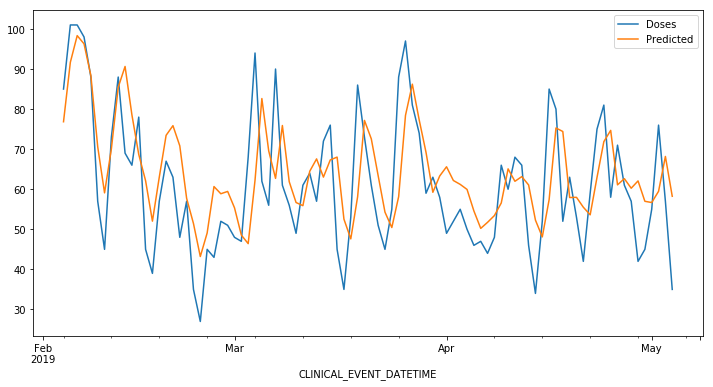

In [167]:
test.plot(legend=True, figsize=(12,6))

In [168]:
mse_rnn = mean_squared_error(test["Doses"], test["Predicted"])
rmse_rnn = rmse(test["Doses"],  test["Predicted"])

print(f'MSE RNN: {mse_rnn:11.10}')
print(f'RMSE RNN: {rmse_rnn:11.10}')

MSE RNN: 172.6529402
RMSE RNN: 13.13974658


In [240]:
first_batch = apap_daily.iloc[-n_back:].values
#current_batch = first_batch.reshape((1, n_back, 1))
current_batch = first_batch.reshape(-1, 1)
current_scaled = scaler.transform(current_batch)

In [245]:
p = model.predict(current_scaled)

ValueError: Error when checking input: expected lstm_10_input to have 3 dimensions, but got array with shape (90, 1)

In [205]:
pred_features = []  
for i in range(len(current_scaled), len(current_scaled) + n_back):  
    pred_features.append(current_scaled[i-n_back:i, 0])
pred_features = np.array(current_scaled)
pred_features = np.reshape(pred_features, (pred_features.shape[0], pred_features.shape[1], 1)) 
pred_features.shape

(90, 1, 1)

In [204]:
model.predict(pred_features)

ValueError: Error when checking input: expected lstm_10_input to have shape (90, 1) but got array with shape (1, 1)

In [ ]:
new_preds = []
first_batch = apap_daily.iloc[-n_back:].values
current_batch = first_batch.reshape((1, n_back, 1))

test_inputs = test_inputs.reshape(-1,1)  
test_inputs = scaler.transform(test_inputs)
test_features = []  
for i in range(n_back, len(test_inputs)):  
    test_features.append(test_inputs[i-n_back:i, 0])
test_features = np.array(test_features)  
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1)) 
predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)  
                               
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_preds.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)